In [1]:
import mne
import numpy as np
import pandas as pd
from scipy.stats import kurtosis, skew
from mne.time_frequency import tfr_morlet

In [2]:
file_path = "C:\Перенос\Доки\Мага брат\Методология научных исследований\ВКР\OpenBCISession_Senya 1\OpenBCI-RAW-2024-04-01_16-48-29.txt"

In [3]:
with open(file_path, mode='r') as f:
    file_info = []
    while (info:=f.readline()[:-1])[0] == '%':
        file_info.append(info)

In [4]:
file_info

['%OpenBCI Raw EXG Data',
 '%Number of channels = 8',
 '%Sample Rate = 250 Hz',
 '%Board = OpenBCI_GUI$BoardCytonSerial']

In [2]:
def bci_df(file_path, skip_rows=4, sfreq=250):
    df = pd.read_csv(file_path, skiprows=skip_rows, skipinitialspace=True)
    step = 1/sfreq
    df['Time'] = np.arange(0, len(df)/250, step)
    cols_to_drop = [col for col in df.columns if not col.startswith('EXG') and col!='Time']
    df = df.drop(columns=cols_to_drop, axis=1)
    # df.iloc[:, :-1] /= 1_000_000 
    return df

def bci_df_to_mne(df, start, end, sfreq=250):
    condition = (df['Time'] >= start) & (df['Time'] <= end) 
    data = df[condition].drop(columns='Time', axis=1).T.to_numpy()
    # data /= 1_000_000
    
    ch_names = df.columns[:-1].tolist()
    info = mne.create_info(ch_names=ch_names, sfreq=sfreq, ch_types=['eeg']*len(ch_names), verbose=False)
    eeg = mne.io.RawArray(data=data, info=info, verbose=False)
    eeg = eeg.set_eeg_reference(verbose=False)
    return eeg

def filter_eeg(data, low_cutoff=1, high_cutoff=40):
    data_filt = data.copy()
    
    data_notched = mne.filter.notch_filter(
                    data_filt.get_data(),
                    Fs=data_filt.info["sfreq"],
                    freqs=[50, 100],
                    # trans_bandwidth=10,
                    # method="spectrum_fit",
                    # mt_bandwidth=2,
                    # p_value=0.01,
                    # filter_length='10s',
                    verbose=False
                )
    data_filt = mne.io.RawArray(data=data_notched, info=data_filt.info, verbose=False)
    
    data_filt.filter(l_freq=low_cutoff, h_freq=high_cutoff, method='iir', verbose=False)

    
    return data_filt

def extract_features(data, epoch_duration=1):
    eeg_epochs = mne.make_fixed_length_epochs(data, epoch_duration, verbose=False)
    
    psd_alpha = eeg_epochs.compute_psd(fmin=8, fmax=13, verbose=False)
    psd_beta = eeg_epochs.compute_psd(fmin=13, fmax=40, verbose=False)
    psd_alpha = psd_alpha.get_data()
    psd_beta = psd_beta.get_data()
    features = np.hstack((psd_alpha.reshape((psd_alpha.shape[0], -1)),
                          psd_beta.reshape((psd_beta.shape[0], -1))))

    mean_powers = []
    for psd in (psd_alpha, psd_beta):
        mean_power = np.mean(psd, axis=2)
        mean_powers.append(mean_power)
        median_power = np.median(psd, axis=2)
        std_power = np.std(psd, axis=2)
        # var_power = np.var(psd, axis=1)
        skewness_power = skew(psd, axis=2)
        kurtosis_power = kurtosis(psd, axis=2)

        features = np.hstack((features, mean_power, median_power, std_power, skewness_power, kurtosis_power))
        # names.append()

    # mean_powers = [a/b for a, b in ]
    # features = np.hstack((features, mean_powers))
    

    # freqs = np.logspace(*np.log10([8, 40]), num=16)  # Использовать linspace???
    # n_cycles = freqs / 2.0  # different number of cycle per frequency
    # power_idle, _ = tfr_morlet(
    #     eeg_idle_epoch,
    #     freqs=freqs,
    #     n_cycles=n_cycles,
    #     use_fft=True,
    #     return_itc=False,
    #     decim=3,
    #     n_jobs=None,
    # )
    
    return features

In [74]:
extract_features(eeg_filt).shape

Not setting metadata
51 matching events found
No baseline correction applied
0 projection items activated
(51, 272)


(51, 352)

In [82]:
eeg_epochs = mne.make_fixed_length_epochs(eeg_filt, 1)
psd = eeg_epochs.compute_psd(fmin=8, fmax=12)


Not setting metadata
51 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 51 events and 250 original time points ...
0 bad epochs dropped
    Using multitaper spectrum estimation with 7 DPSS windows


In [87]:
file_path = "C:\Перенос\Доки\Мага брат\Методология научных исследований\ВКР\OpenBCISession_2024-04-05_16-44-31 Senya 0\OpenBCI-RAW-2024-04-05_16-49-19.txt"
df = bci_df(file_path)

In [88]:
df

,EXG Channel 0,EXG Channel 1,EXG Channel 2,EXG Channel 3,EXG Channel 4,EXG Channel 5,EXG Channel 6,EXG Channel 7,Time
0,4340.708773,12975.746450,-48678.411386,48915.943374,6187.655769,-23258.375914,-29337.402205,-25295.335090,0.000
1,4365.653320,12999.595761,-48653.645653,48934.383563,6211.236860,-23239.086358,-29304.835713,-25276.604328,0.004
2,4381.366596,13009.721101,-48593.050074,48927.856854,6205.157185,-23258.152396,-29371.376857,-25301.548875,0.008
3,4368.939026,12996.421814,-48571.167716,48904.052246,6179.810307,-23289.713060,-29441.069596,-25336.909334,0.012
4,4347.257834,12983.770726,-48620.140388,48899.179566,6176.077566,-23282.806371,-29404.725659,-25328.616837,0.016
...,...,...,...,...,...,...,...,...,...
22996,4890.740501,13817.021408,-48407.687057,50932.003669,6394.677626,-23498.768926,-29750.440091,-23496.533751,91.984
22997,4889.578210,13812.953390,-48396.645295,50921.967736,6383.077071,-23514.191629,-29813.919045,-23510.123612,91.988
22998,4863.761945,13796.256637,-48451.049441,50920.738390,6383.501754,-23500.534713,-29710.229303,-23496.533751,91.992
22999,4849.076849,13788.947617,-48496.445834,50932.562462,6396.421063,-23473.399696,-29576.990554,-23470.471617,91.996


In [89]:
eeg = bci_df_to_mne(df, 20, 72)
eeg_filt = filter_eeg(eeg)
eeg_filt.save("C:\Перенос\Доки\Мага брат\Методология научных исследований\ВКР\Отфильтрованные записи\Спокойствие\senya_2_raw.fif")

Writing C:\Перенос\Доки\Мага брат\Методология научных исследований\ВКР\Отфильтрованные записи\Спокойствие\senya_2_raw.fif
Closing C:\Перенос\Доки\Мага брат\Методология научных исследований\ВКР\Отфильтрованные записи\Спокойствие\senya_2_raw.fif
[done]


In [26]:
np.array(extract_features(eeg_filt)).shape

Not setting metadata
51 matching events found
No baseline correction applied
0 projection items activated


(10, 51, 8)

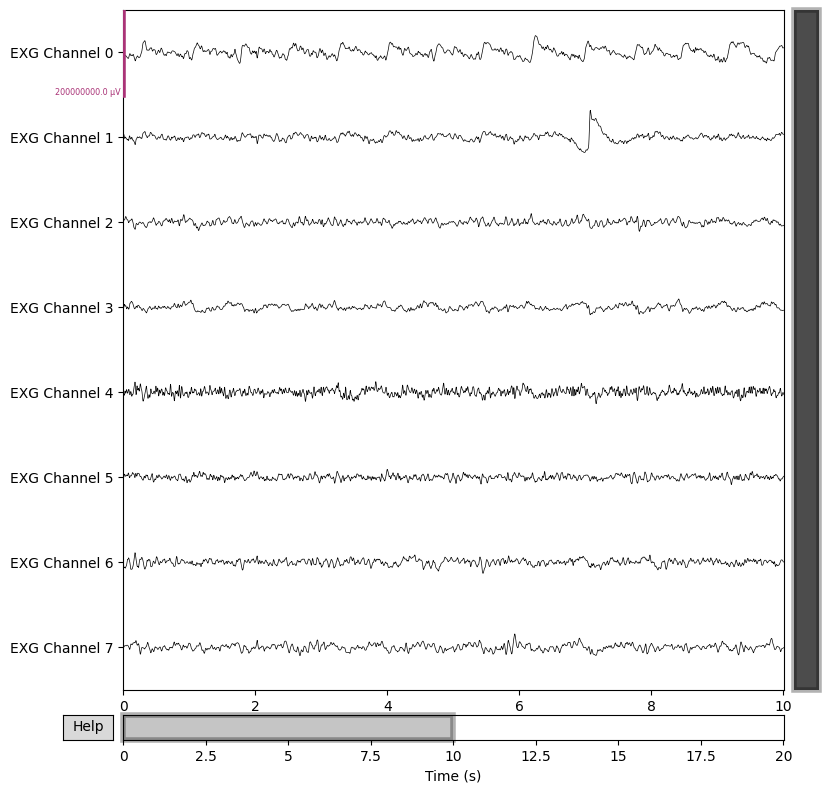

In [38]:
eeg_filt.plot(scalings=100);


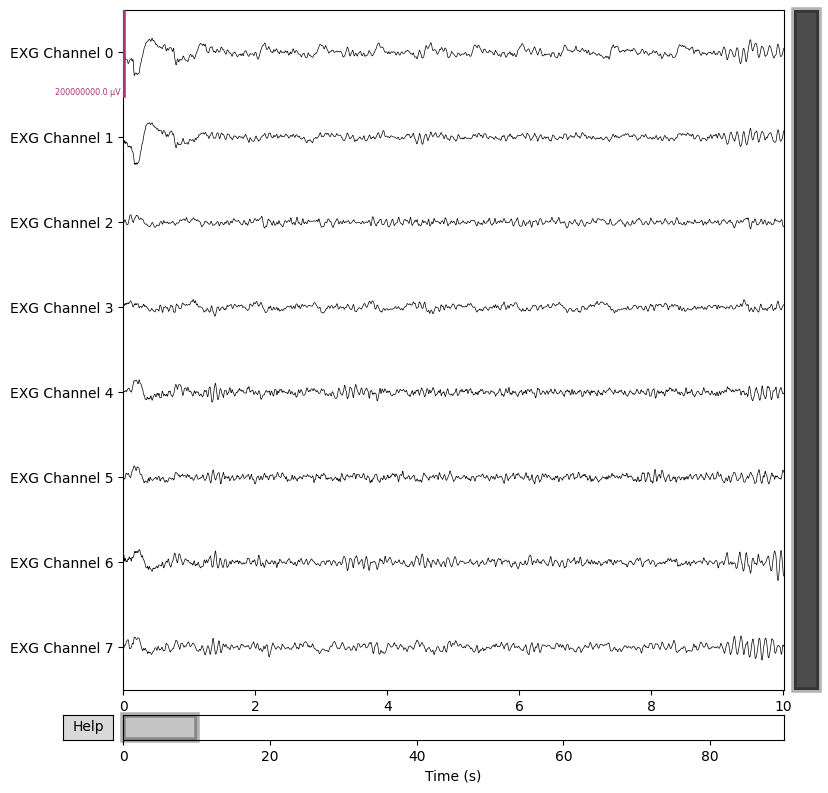

In [35]:
eeg_filt.plot(scalings=100);

In [44]:
# eeg_filt.set_montage(mne.channels.make_standard_montage("standard_1020"))

NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 8.192 (s)


C:\Users\Арсений\AppData\Local\Programs\Python\Python311\Lib\site-packages\mne\viz\utils.py:165: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)


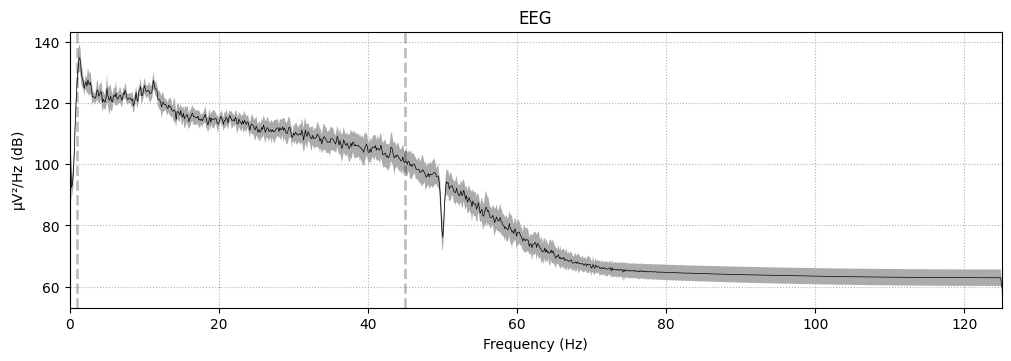

In [45]:
eeg_filt.plot_psd(average=True)

51.0

In [69]:
eeg_epoch = mne.make_fixed_length_epochs(eeg_filt, eeg_filt.times[-1])

Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated


In [71]:
power.data.shape

(8, 16, 4250)

In [70]:
freqs = np.logspace(*np.log10([4, 40]), num=16)
n_cycles = freqs / 2.0  # different number of cycle per frequency
power, itc = tfr_morlet(
    eeg_epoch,
    freqs=freqs,
    n_cycles=n_cycles,
    use_fft=True,
    return_itc=True,
    decim=3,
    n_jobs=None,
)

Using data from preloaded Raw for 1 events and 12750 original time points ...
0 bad epochs dropped


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s finished


No baseline correction applied


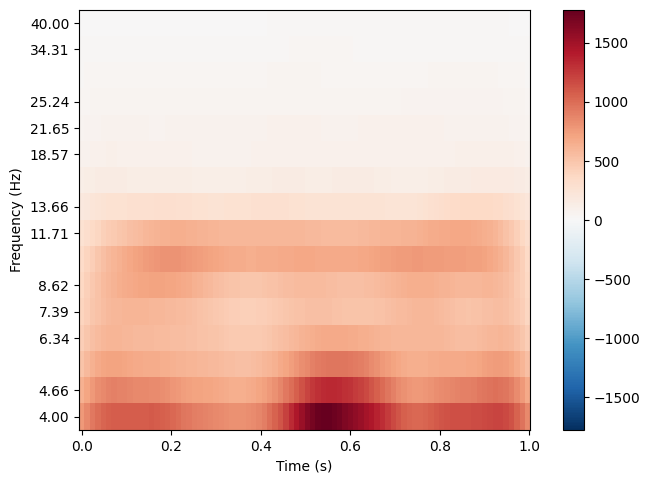

In [72]:
power.plot(combine='mean', mode='logratio');

In [4]:
file_path = "C:\Перенос\Доки\Мага брат\Методология научных исследований\ВКР\OpenBCISession_Masha 1\OpenBCI-RAW-2024-04-01_16-31-02.txt"
df = bci_df(file_path)

eeg = bci_df_to_mne(df, 96, 276)
eeg_filt = filter_eeg(eeg)
eeg_filt.save("C:\Перенос\Доки\Мага брат\Методология научных исследований\ВКР\Отфильтрованные записи\Релакс\masha_0_raw.fif")

Writing C:\Перенос\Доки\Мага брат\Методология научных исследований\ВКР\Отфильтрованные записи\Релакс\masha_0_raw.fif
Closing C:\Перенос\Доки\Мага брат\Методология научных исследований\ВКР\Отфильтрованные записи\Релакс\masha_0_raw.fif
[done]


In [73]:
eeg_idle_epoch = mne.make_fixed_length_epochs(eeg_idle_filt, 1)

freqs = np.logspace(*np.log10([4, 40]), num=16)
n_cycles = freqs / 2.0  # different number of cycle per frequency
power_idle, itc = tfr_morlet(
    eeg_idle_epoch,
    freqs=freqs,
    n_cycles=n_cycles,
    use_fft=True,
    return_itc=True,
    decim=3,
    n_jobs=None,
)

Not setting metadata
60 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 60 events and 250 original time points ...
0 bad epochs dropped


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.4s finished


No baseline correction applied


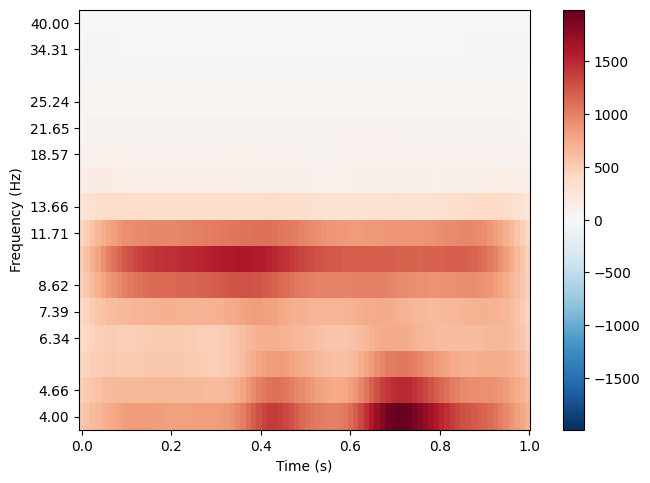

In [74]:
power_idle.plot(combine='mean', mode='logratio');

NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 8.192 (s)


C:\Users\Арсений\AppData\Local\Programs\Python\Python311\Lib\site-packages\mne\viz\utils.py:165: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)


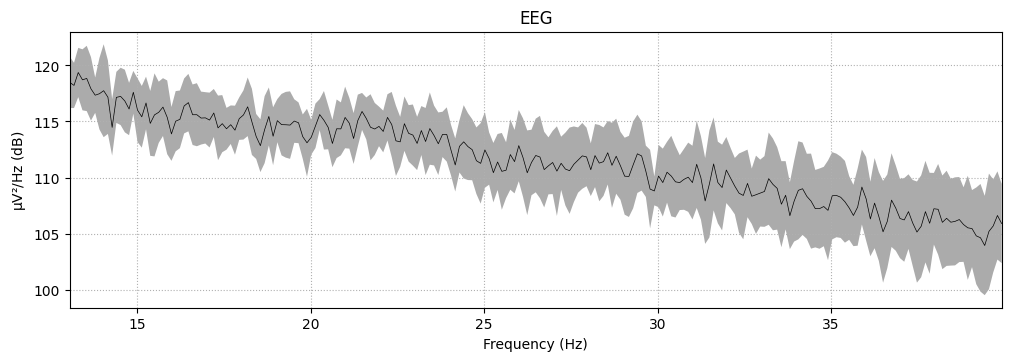

In [80]:
eeg_filt.plot_psd(fmin=13, fmax=40, average=True)

NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 8.192 (s)


C:\Users\Арсений\AppData\Local\Programs\Python\Python311\Lib\site-packages\mne\viz\utils.py:165: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)


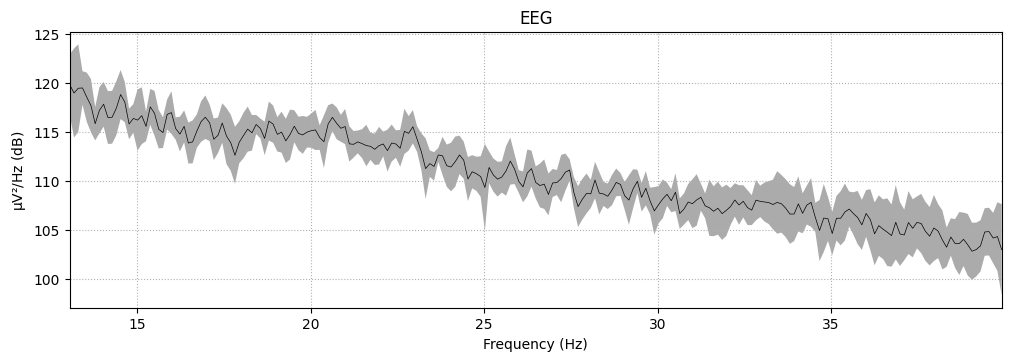

In [81]:
eeg_idle_filt.plot_psd(fmin=13, fmax=40, average=True)

In [3]:
eeg_filt = mne.io.read_raw("C:\Перенос\Доки\Мага брат\Методология научных исследований\ВКР\Отфильтрованные записи\Стресс\senya_0_raw.fif")

Opening raw data file C:\Перенос\Доки\Мага брат\Методология научных исследований\ВКР\Отфильтрованные записи\Стресс\senya_0_raw.fif...
Isotrak not found
    Range : 0 ... 17750 =      0.000 ...    71.000 secs
Ready.


In [69]:
eeg_epoch = mne.make_fixed_length_epochs(eeg_filt, 5)

Not setting metadata
14 matching events found
No baseline correction applied
0 projection items activated


In [35]:
psd = eeg_filt.compute_psd(tmax=5)

Effective window size : 5.004 (s)


C:\Users\Арсений\AppData\Local\Programs\Python\Python311\Lib\site-packages\mne\viz\utils.py:165: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)


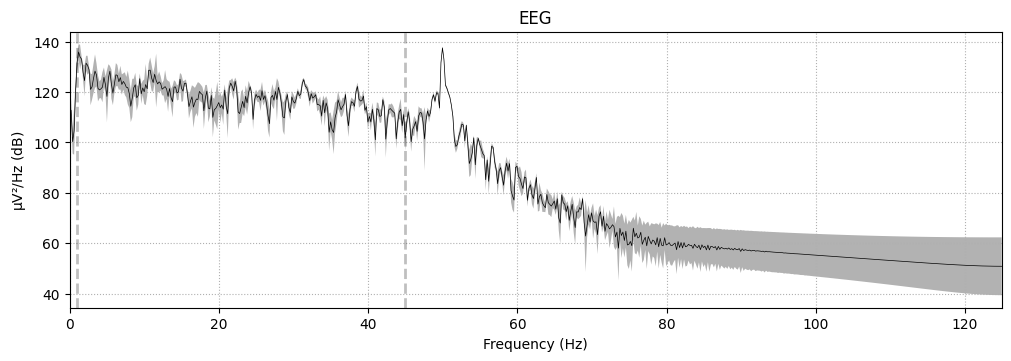

In [36]:
psd.plot(average=True)

In [37]:
psd.get_data(fmin=8, fmax=12)

array([[2.28103756e+00, 2.58574061e+00, 9.60656626e-01, 1.71348546e-01,
        1.30699142e-01, 6.35470291e-01, 1.77346640e+00, 1.29582496e+00,
        1.17990306e+00, 5.62147306e-01, 4.85272037e-02, 1.71605191e+00,
        5.86031392e+00, 2.21369913e+00, 3.07242712e-01, 2.97004643e-01,
        3.37886080e+00, 9.85479289e+00, 1.40358702e+00, 1.64749754e+00],
       [8.19339191e-01, 1.12038624e+00, 1.52595015e+00, 1.71555875e+00,
        8.95239245e-01, 9.62063291e-01, 2.69709953e+00, 1.29230840e+00,
        1.45621473e+00, 9.36914313e-02, 2.13852166e-01, 7.00462688e-01,
        2.98014181e+00, 1.20987763e+00, 2.05940392e+00, 2.23699598e+00,
        2.43400800e+00, 1.18750283e+01, 3.47493351e+00, 4.10604618e+00],
       [1.45001150e-01, 3.09774144e-01, 8.80045879e-01, 3.88830780e+00,
        3.53645521e+00, 5.04236513e-01, 5.45465333e+00, 2.19213997e+00,
        3.87177284e-01, 1.70516751e+00, 3.17861391e+00, 1.31412954e+00,
        6.28492843e+00, 5.17298452e+00, 6.58367938e+00, 2.8935

In [5]:
eeg_stress = mne.io.read_raw("C:\Перенос\Доки\Мага брат\Методология научных исследований\ВКР\Отфильтрованные записи\Стресс\masha_0_raw.fif")

Opening raw data file C:\Перенос\Доки\Мага брат\Методология научных исследований\ВКР\Отфильтрованные записи\Стресс\masha_0_raw.fif...
Isotrak not found
    Range : 0 ... 16250 =      0.000 ...    65.000 secs
Ready.


In [6]:
features = extract_features(eeg_stress)

In [7]:
features.shape

(65, 352)

In [112]:
all_features = np.vstack((all_features, features))

In [113]:
all_features.shape

(141, 352)

In [8]:
stress_features = np.hstack((np.ones((features.shape[0], 1)), features))

In [11]:
stress_features

array([[ 1.00000000e+00,  1.78281318e+03,  8.17083875e+02, ...,
         1.03624784e+01, -1.16363817e+00, -1.38012201e+00],
       [ 1.00000000e+00,  5.05419625e+02,  5.04543928e+02, ...,
         1.58113806e+00,  4.61347126e+00, -4.40823281e-01],
       [ 1.00000000e+00,  2.32631122e+02,  2.27312024e+02, ...,
        -1.37588474e+00,  3.14522959e-01,  4.40001815e-01],
       ...,
       [ 1.00000000e+00,  4.46985051e+03,  2.49658960e+03, ...,
        -1.01381739e+00,  2.53210855e+00, -8.09267926e-01],
       [ 1.00000000e+00,  8.74194017e+02,  6.81178375e+02, ...,
        -7.22798776e-01, -1.72293791e-02, -1.29605844e+00],
       [ 1.00000000e+00,  1.08238751e+03,  9.55172729e+02, ...,
        -1.44931242e+00,  2.19212765e-01, -3.24977378e-01]])

In [115]:
g = np.random.rand(2, 3)

In [122]:
np.hstack((np.ones((2, 1)), g))

array([[1.        , 0.84839958, 0.5786581 , 0.53475118],
       [1.        , 0.26203493, 0.53967951, 0.35613906]])

In [23]:
eeg_idle = mne.io.read_raw("C:\Перенос\Доки\Мага брат\Методология научных исследований\ВКР\Отфильтрованные записи\Релакс\senya_0_raw.fif")

Opening raw data file C:\Перенос\Доки\Мага брат\Методология научных исследований\ВКР\Отфильтрованные записи\Релакс\senya_0_raw.fif...
Isotrak not found
    Range : 0 ... 45000 =      0.000 ...   180.000 secs
Ready.


In [24]:
features_idle = extract_features(eeg_idle)

In [131]:
all_features_idle = features_idle.copy()

In [142]:
all_features_idle = np.vstack((all_features_idle, features_idle[100:150]))

In [143]:
all_features_idle.shape

(133, 352)

In [26]:
all_features_idle = np.hstack((np.zeros((features_idle.shape[0], 1)), features_idle))

In [29]:
all_features_idle

array([[0.00000000e+00, 1.34131485e+03, 1.22948816e+03, ...,
        2.83660806e+00, 2.69697222e+00, 5.30825218e+00],
       [0.00000000e+00, 6.42717880e+02, 5.48906366e+02, ...,
        9.53805260e+00, 5.10286620e+00, 5.74999614e+00],
       [0.00000000e+00, 1.95251166e+03, 7.00102228e+02, ...,
        1.06955918e+00, 3.54103621e+00, 2.06689414e+00],
       ...,
       [0.00000000e+00, 9.07135621e+02, 8.14444942e+02, ...,
        4.22161172e+00, 2.39226241e+00, 8.21854416e+00],
       [0.00000000e+00, 9.57531786e+02, 6.31332428e+02, ...,
        3.85120241e+00, 9.62584466e-01, 3.30405250e+00],
       [0.00000000e+00, 1.19807173e+03, 6.58740193e+02, ...,
        4.51868252e+00, 3.94504024e+00, 4.16935782e+00]])

In [148]:
all_features = np.vstack((all_features_idle, stress_features))

In [30]:
with open(r"C:\Перенос\Доки\Мага брат\Методология научных исследований\ВКР\Отфильтрованные записи\Признаки\features_relax_senya_01.npy", mode='wb') as f:
    np.save(f, all_features_idle)

In [31]:
with open(r"C:\Перенос\Доки\Мага брат\Методология научных исследований\ВКР\Отфильтрованные записи\Признаки\features_01.npy", mode='rb') as f:
    all_feat_train = np.load(f)

In [13]:
with open(r"C:\Перенос\Доки\Мага брат\Методология научных исследований\ВКР\Отфильтрованные записи\Признаки\features_stress_masha_01.npy", mode='rb') as f:
    a = np.load(f)

In [14]:
a.shape

(65, 353)

In [33]:
with open(r"C:\Перенос\Доки\Мага брат\Методология научных исследований\ВКР\Отфильтрованные записи\Признаки\features_relax_senya_01.npy", mode='rb') as f:
    feat_relax = np.load(f)

In [35]:
feat_relax = feat_relax[:60]

In [40]:
all_feat_train = np.vstack((all_feat_train, feat_relax))

In [41]:
with open(r"C:\Перенос\Доки\Мага брат\Методология научных исследований\ВКР\Отфильтрованные записи\Признаки\features_02.npy", mode='wb') as f:
    np.save(f, all_feat_train)